In [73]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
print(tf.__version__)

2.15.0


In [74]:
import numpy as np

In [75]:
import scipy.signal as signal
import scipy.io.wavfile as wav

# this function resamples audio from a original sample rate to a target sample rate
def resample_audio(wav, orig_sr, target_sr):
    resampled_wav = signal.resample(wav, int(len(wav) * target_sr / orig_sr))
    return resampled_wav

In [76]:
# returns a TensorFlow Tensor which contains the audio waveform after it
#has been resampled to a mono signal with a sampling rate of 16000 Hz
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav_np = tf.numpy_function(np.squeeze, [wav], tf.float32)
    # Resample to 16000Hz
    resampled_wav = tf.numpy_function(resample_audio, [wav_np, sample_rate, 16000], tf.float32)
    # Convert back to TensorFlow tensor
    resampled_wav = tf.convert_to_tensor(resampled_wav)
    return resampled_wav

In [77]:
path = 'C:/Users/maziy/Documents/smart_water/flexible_data/'

files = []
for f in os.listdir(path):
    files.append(f)

In [78]:
files

['flexible15.wav']

In [80]:
!pip install pydub


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: C:\Users\maziy\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [81]:
from pydub import AudioSegment

In [82]:
# Directory where the chopped audio segments will be saved
chopped_dir = 'C:/Users/maziy/Documents/smart_water/flexible_chopped/'

def split_and_save_audio(input_audio_file, category, num_segments):
    audio = AudioSegment.from_wav(input_audio_file)

    for i in range(num_segments):
        t1 = i * 1000  # Start time in milliseconds
        t2 = (i + 1) * 1000  # End time in milliseconds
        segment = audio[t1:t2]

        output_file = os.path.join(chopped_dir+category, f'{category}_{i}chopped.wav')
        segment.export(output_file, format="wav")

# Split and save positive and negative audio segments
num_segments = 90
for i in files:
    split_and_save_audio(path+i, i.split('.')[0], num_segments)


In [83]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    chopped_dir,
    batch_size=5,
    validation_split=0.2,
    seed=0,
    output_sequence_length=44100,
    subset='both'
)

Found 90 files belonging to 1 classes.
Using 72 files for training.
Using 18 files for validation.


In [84]:
label_names = np.array(train_ds.class_names)
label_names

array(['flexible15'], dtype='<U10')

In [85]:
train_ds.element_spec

(TensorSpec(shape=(None, 44100, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [86]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)


In [87]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)


(5, 44100)
(5,)


In [88]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)


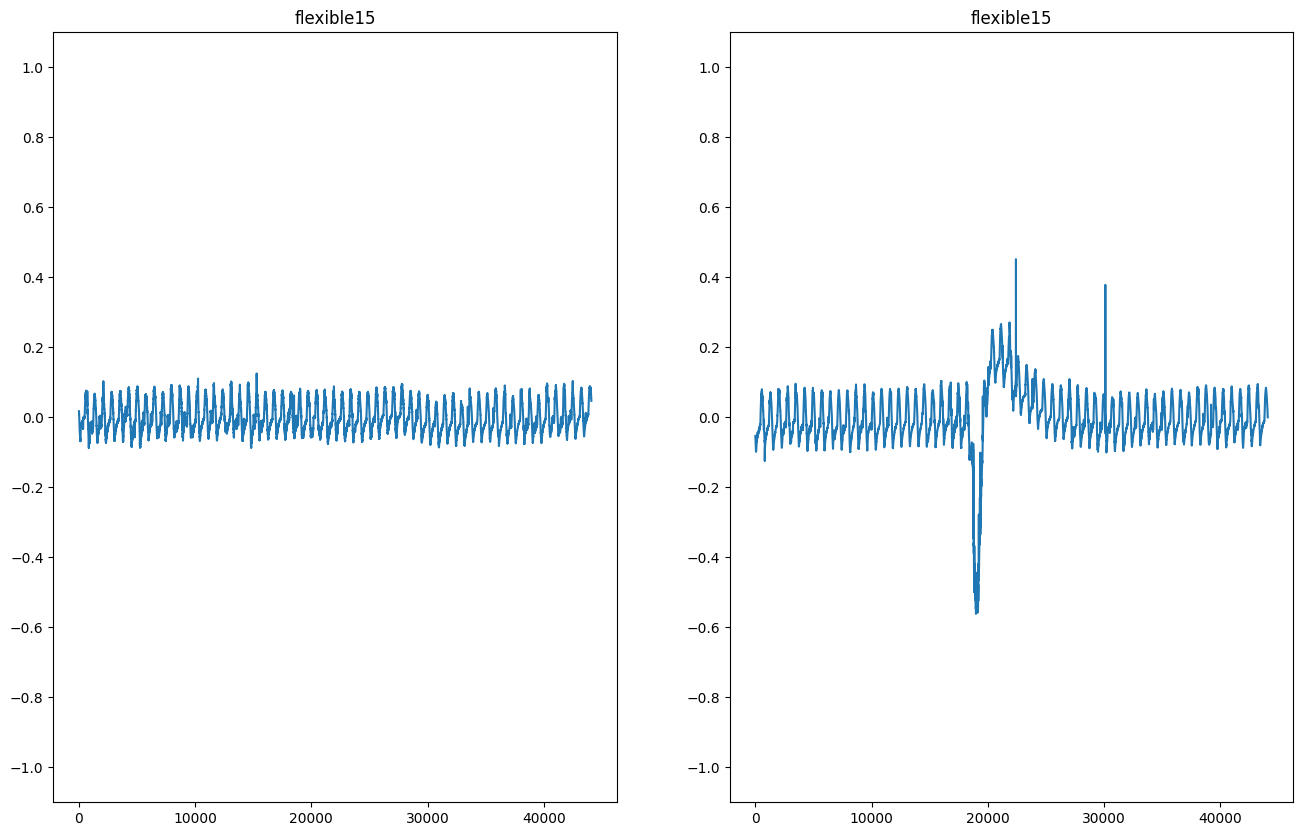

In [89]:
plt.figure(figsize=(16, 10))
rows = 1
cols = 2
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])


#Neural Network

In [90]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [91]:
for i in range(1):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')


Label: flexible15
Waveform shape: (44100,)
Spectrogram shape: (343, 129, 1)
Audio playback


In [92]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


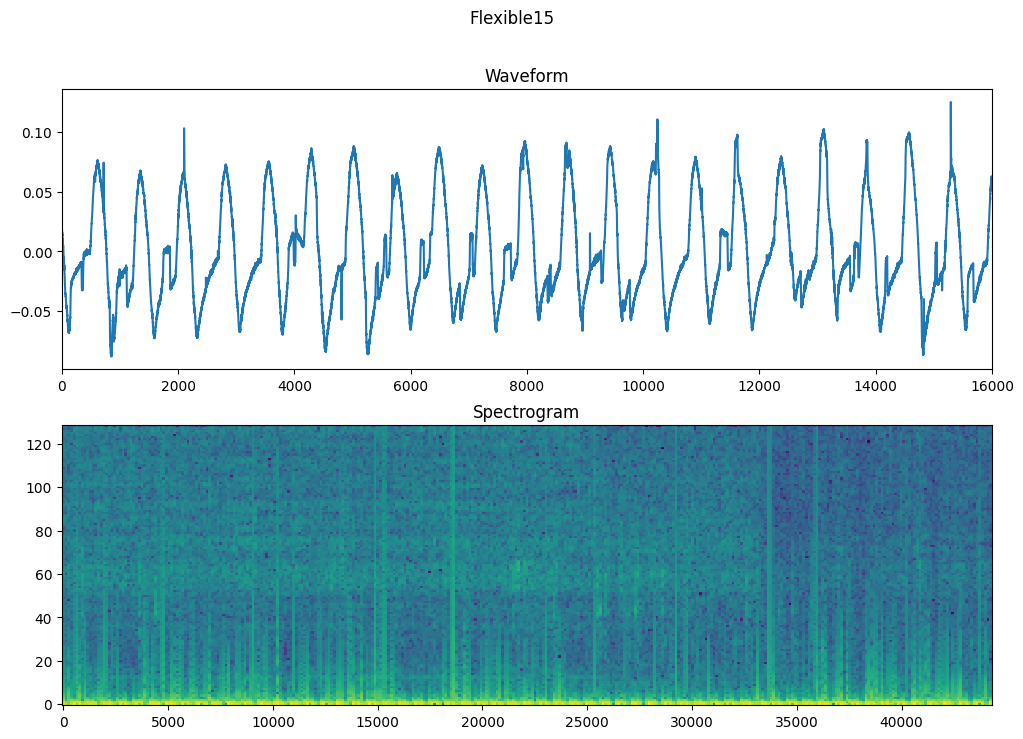

In [93]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()
